# Competição DSA de Machine Learning - Edição Dezembro/2019
Você está recebendo um conjunto de dados anônimos contendo variáveis categóricas e numéricas disponíveis quando os pedidos de indenizações foram recebidos pela seguradora. Todas as variáveis do tipo string são categóricas. Não há variáveis ordinais.  
**A tarefa é prever uma probabilidade ("PredictedProb") para cada pedido de indenização no conjunto de testes.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as sci
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from skopt import dummy_minimize

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

C:\Users\lucas\Anaconda3\envs\datacamp\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data Input

In [2]:
PATH = 'datasrc/'
FILES = ['dataset_treino.csv', 'dataset_teste.csv', 'sample_submission.csv']
datasets = dict()

for FILE in FILES:
    datasets[FILE] = pd.read_csv(PATH+FILE)
    print(f'{FILE} possui {datasets[FILE].shape[0]} linhas e {datasets[FILE].shape[1]} colunas.\n')

dataset_treino.csv possui 114321 linhas e 133 colunas.

dataset_teste.csv possui 114393 linhas e 132 colunas.

sample_submission.csv possui 114393 linhas e 2 colunas.



In [3]:
train = datasets['dataset_treino.csv']
test = datasets['dataset_teste.csv']
sample_submission = datasets['sample_submission.csv']

In [4]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


## Data Cleaning
### Dtypes

In [5]:
#Treino
train.dtypes.value_counts()

float64    108
object      19
int64        6
dtype: int64

In [6]:
#Teste
test.dtypes.value_counts()

float64    108
object      19
int64        5
dtype: int64

### Variáveis contínuas (float64)

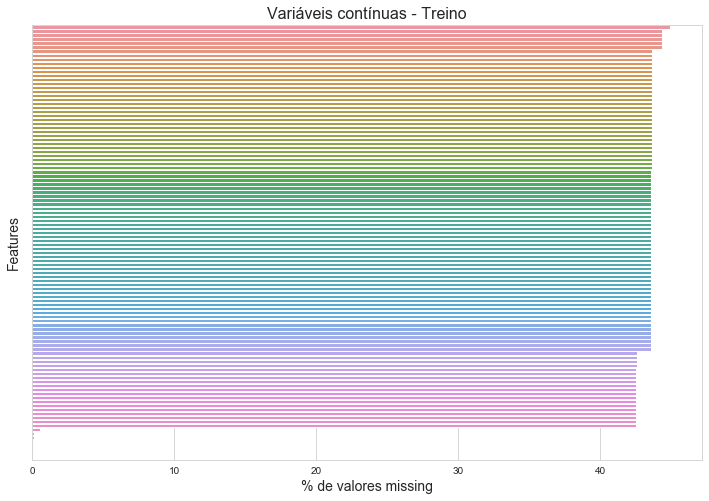

In [7]:
#Treino
data = ((train.select_dtypes('float64').isnull().sum().sort_values(ascending=False) / len(train)) * 100).reset_index()
data.columns = ['feature', 'value']

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_yticklabels('')
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Treino', fontsize = 16)
plt.show()


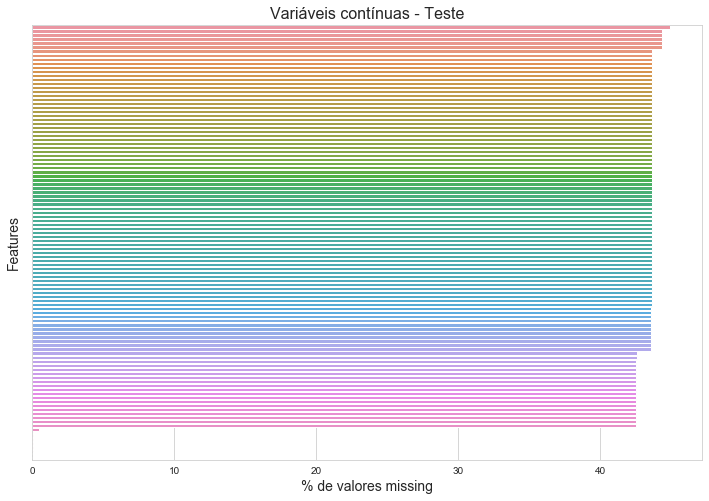

In [8]:
#Teste
data = ((test.select_dtypes('float64').isnull().sum().sort_values(ascending=False) / len(test)) * 100).reset_index()
data.columns = ['feature', 'value']

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_yticklabels('')
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Teste', fontsize = 16)
plt.show()

Em uma primeira análise, é possível notar que uma parte massiva das variáveis contínuas possuem mais de 40% de seus valores nulos. Vamos avaliar numericamente qual a situação das variáveis que possuem poucos valores nulos.

In [9]:
#Treino
data = ((train.select_dtypes('float64').isnull().sum().sort_values(ascending=False) / len(train)) * 100).reset_index()
data.columns = ['feature', 'value']
data.loc[data.value < 40]


,feature,value
100,v21,0.534460
101,v40,0.097095
102,v34,0.097095
103,v12,0.075227
104,v50,0.075227
105,v10,0.073477
106,v114,0.026242
107,v14,0.003499


In [10]:
#Teste
data = ((test.select_dtypes('float64').isnull().sum().sort_values(ascending=False) / len(test)) * 100).reset_index()
data.columns = ['feature', 'value']
data.loc[data.value < 40]

,feature,value
100,v21,0.500905
101,v34,0.090915
102,v40,0.090915
103,v12,0.073431
104,v50,0.073431
105,v10,0.071683
106,v114,0.020980
107,v14,0.001748


Aparentemente o comportamento é o mesmo, a discrepância enorme em missing values (0.5% para 40%) ocorre para treino e para teste, além disso, as mesmas features em treino e teste possuem % de missing menor que 40%.

Outro ponto a se observar é o fato de que valores missing costumam ocorrer nos mesmos registros, vamos observar para o critério da feature v102 (cerca de 45% de valores missing) diversos outros registros também aparecem zerados.

In [11]:
train.loc[train.v102.isnull(), :].head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
5,9,0,NaN,NaN,C,NaN,8.856791,NaN,NaN,0.359993,...,NaN,NaN,0.049861,X,NaN,NaN,1.536222,0,NaN,NaN
7,21,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BY,NaN,NaN,NaN,0,NaN,NaN
10,24,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AR,NaN,NaN,NaN,0,NaN,NaN


In [12]:
test.loc[test.v102.isnull(), :].head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
3,7,2.66187,3.041241,C,1.657216,9.77308,2.078337,1.430855,1.252157,7.959596,...,4.40404,8.163614,1.100329,B,1.988688,1.558753,2.448814,0,5.385474,1.493777
6,13,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CK,NaN,NaN,NaN,0,NaN,NaN
9,16,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AN,NaN,NaN,NaN,0,NaN,NaN
10,17,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN


**Para as variáveis contínuas que possuem % de missing maior que 40%, a melhor decisão aparenta ser o abandono dessas features.**

### Variáveis Categóricas (Object)

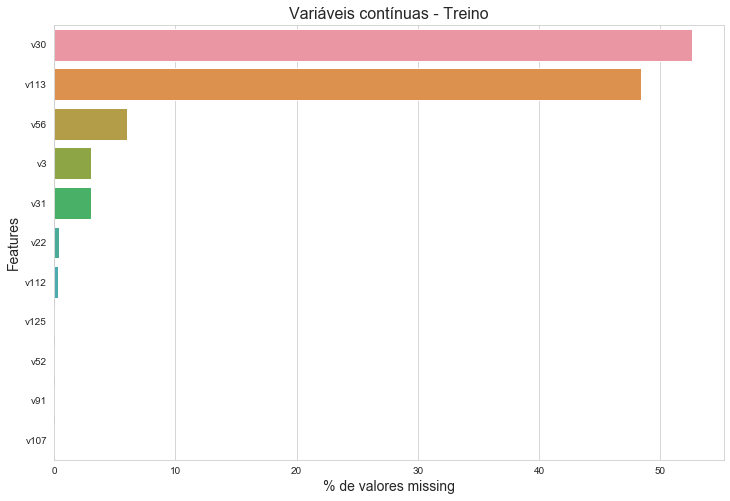

In [13]:
#Treino
data = ((train.select_dtypes('object').isnull().sum().sort_values(ascending=False) / len(train)) * 100).reset_index()
data.columns = ['feature', 'value']
data = data.loc[data.value > 0]

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Treino', fontsize = 16)
plt.show()

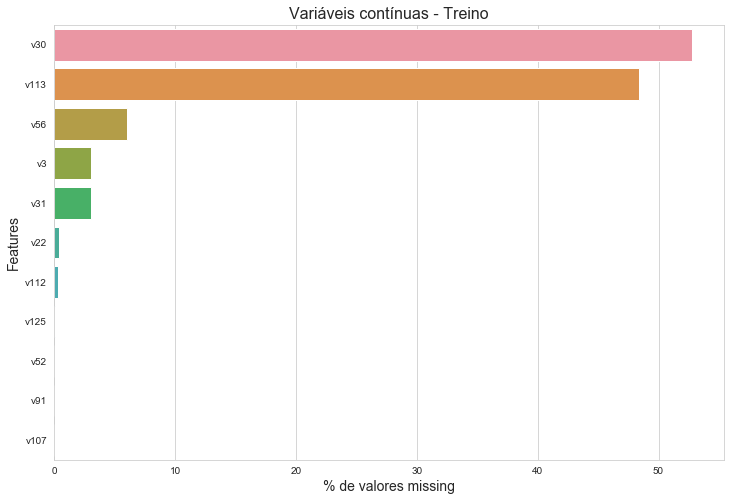

In [14]:
#Teste
data = ((test.select_dtypes('object').isnull().sum().sort_values(ascending=False) / len(test)) * 100).reset_index()
data.columns = ['feature', 'value']
data = data.loc[data.value > 0]

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Treino', fontsize = 16)
plt.show()

Para as categóricas encodadas como object, as features v30 e v113 apresentam uma alta porcentagem de nulos para treino e para teste.

### Inteiros

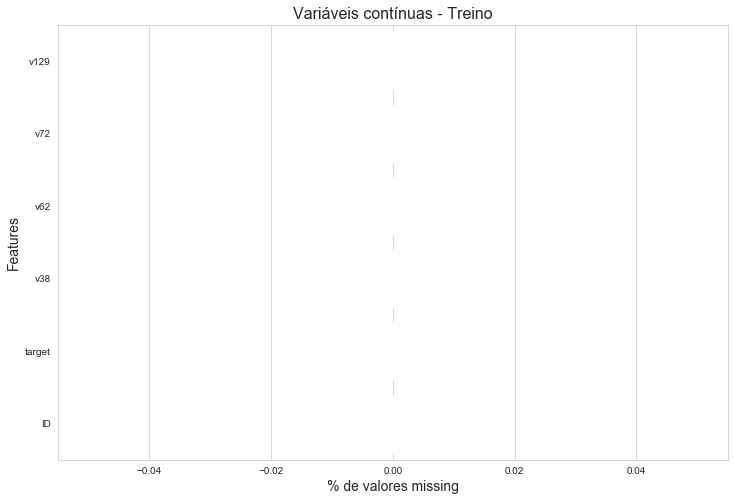

In [15]:
#Treino
data = ((train.select_dtypes('int64').isnull().sum().sort_values(ascending=False) / len(train)) * 100).reset_index()
data.columns = ['feature', 'value']


fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Treino', fontsize = 16)
plt.show()

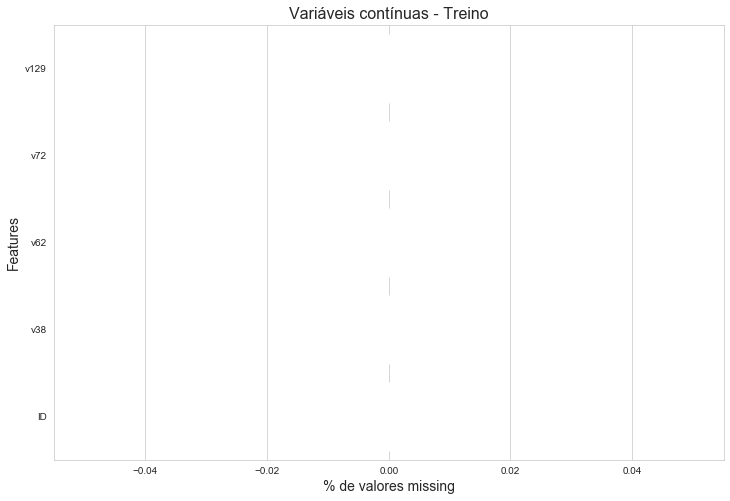

In [16]:
#Teste
data = ((test.select_dtypes('int64').isnull().sum().sort_values(ascending=False) / len(test)) * 100).reset_index()
data.columns = ['feature', 'value']


fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=data, x = 'value', y = 'feature', ax = ax)
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('% de valores missing', fontsize = 14)
ax.set_title('Variáveis contínuas - Treino', fontsize = 16)
plt.show()

Os valores encodados como integer não possuem nenhum valor missing, ótimo!  
Agora, vamos observar os integers.

In [17]:
train.select_dtypes('int64').describe()

,ID,target,v38,v62,v72,v129
count,114321.000000,114321.000000,114321.000000,114321.000000,114321.000000,114321.000000
mean,114228.928228,0.761199,0.090928,1.030694,1.431767,0.310144
std,65934.487362,0.426353,0.583478,0.696244,0.922267,0.693262
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57280.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,114189.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,171206.000000,1.000000,0.000000,1.000000,2.000000,0.000000
max,228713.000000,1.000000,12.000000,7.000000,12.000000,11.000000


In [18]:
test.select_dtypes('int64').describe()

,ID,v38,v62,v72,v129
count,114393.000000,114393.000000,114393.000000,114393.000000,114393.000000
mean,114483.991477,0.088021,1.030649,1.426259,0.307589
std,66113.754997,0.568255,0.695279,0.917787,0.686654
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57074.000000,0.000000,1.000000,1.000000,0.000000
50%,114513.000000,0.000000,1.000000,1.000000,0.000000
75%,171838.000000,0.000000,1.000000,2.000000,0.000000
max,228709.000000,12.000000,7.000000,12.000000,11.000000


### Aplicando as considerações até aqui
De maneira resumida, devemos realizar as seguintes operações:
- Para variáveis encodadas como 'float64', devemos remover aquelas que possuem % de missing maior que 40%.
- Para as variáveis encodadas como 'object', devemos remover somente duas variáveis: v30 e v113.
- Preencher os valores nulos das variáveis restantes de maneira apropriada.

In [19]:
#Dropando missing baseado em um threshold

def drop_percent(dataframe, threshold):
    percent = ((dataframe.isnull().sum() / len(dataframe)) * 100)
    to_drop = percent[percent > threshold].index.tolist()
    dataframe.drop(to_drop, axis = 1, inplace = True)

#Treino
drop_percent(train, 40)
#Teste
drop_percent(test, 40)

#Conferindo resultado
((train.isnull().sum() / len(train)) * 100).sort_values(ascending=False).head()
    

v56    6.019891
v31    3.023941
v3     3.023941
v21    0.534460
v22    0.437365
dtype: float64

In [20]:
#Conferindo se as features de treino estão alinhadas com teste

set(train.drop('target', axis = 1).columns.tolist()) == set(test.columns.tolist())

True

In [21]:
#Conferindo o dataframe final

train.head()

,ID,target,v3,v10,v12,v14,v21,v22,v24,v31,...,v74,v75,v79,v91,v107,v110,v112,v114,v125,v129
0,3,1,C,0.503281,6.085711,11.636387,7.730923,XDX,C,A,...,B,D,E,A,E,B,O,15.634907,AU,0
1,4,1,C,1.312910,6.507647,11.636386,6.763110,GUV,C,A,...,B,D,D,B,B,A,U,10.308044,AF,0
2,5,1,C,0.765864,6.384670,9.603542,5.245035,FQ,E,A,...,B,B,E,G,C,B,S,11.205561,AE,2
3,6,1,C,6.542669,9.646653,14.094723,7.517125,ACUE,D,B,...,B,D,B,B,B,B,J,13.777666,CJ,1
4,8,1,C,1.050328,6.320087,10.991098,6.414567,HIT,E,A,...,B,D,C,G,C,A,T,14.097099,Z,0


### Inputando Valores

In [22]:
#Para variáveis contínuas -> mean

def fill_mean(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == 'float64':
            dataframe[col].fillna(value = dataframe[col].mean(), inplace=True)

#Treino
fill_mean(train)

#Teste
fill_mean(test)

In [23]:
#Verificando
train.isnull().sum()

ID           0
target       0
v3        3457
v10          0
v12          0
v14          0
v21          0
v22        500
v24          0
v31       3457
v34          0
v38          0
v40          0
v47          0
v50          0
v52          3
v56       6882
v62          0
v66          0
v71          0
v72          0
v74          0
v75          0
v79          0
v91          3
v107         3
v110         0
v112       382
v114         0
v125        77
v129         0
dtype: int64

In [24]:
#Para variáveis categóricas -> Termo mais frequente
def fill_categorical(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == 'O':
            most_frequent = dataframe[col].value_counts().index[0]
            dataframe[col].fillna(most_frequent, inplace = True)

#Treino
fill_categorical(train)

#Teste
fill_categorical(test)

In [25]:
#Verificando
print(f'Para treino: {train.isnull().any().any()}')
print(f'Para teste: {test.isnull().any().any()}')

Para treino: False
Para teste: False


### One-Hot Encoding para categóricas
Primeiro, vamos conferir o comportamento das variáveis categóricas.

In [26]:
train.select_dtypes('object').head()

,v3,v22,v24,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v125
0,C,XDX,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,AU
1,C,GUV,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,AF
2,C,FQ,E,A,C,F,AS,A,B,B,B,E,G,C,B,S,AE
3,C,ACUE,D,B,C,H,BW,A,F,B,D,B,B,B,B,J,CJ
4,C,HIT,E,A,I,H,BW,C,F,B,D,C,G,C,A,T,Z


In [27]:
train.select_dtypes('object').nunique()

v3          3
v22     18210
v24         5
v31         3
v47        10
v52        12
v56       122
v66         3
v71         9
v74         3
v75         4
v79        18
v91         7
v107        7
v110        3
v112       22
v125       90
dtype: int64

Ok, se quisermos aplicar One-Hot encoding as features v22, v56 e v125 podem ser problemáticas pois deixarão os dados extremamente esparsos (v22 especialmente). Creio que para modelos que se baseiam em árvores, um simples LabelEncoder nessas variáveis resolve nosso problema, porém, para modelos lineares isso pode ser um problema.

## EDA
Todo mundo gosta de gráficos!

Começando pelo target.

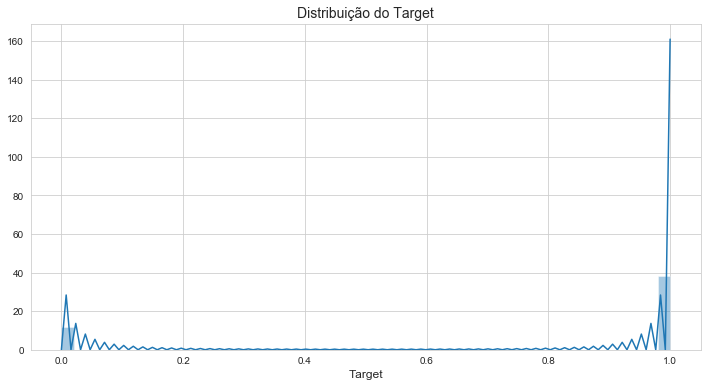

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(train['target'], ax = ax)
ax.set_xlabel('Target', fontsize=12)
ax.set_title('Distribuição do Target', fontsize = 14)
plt.show()

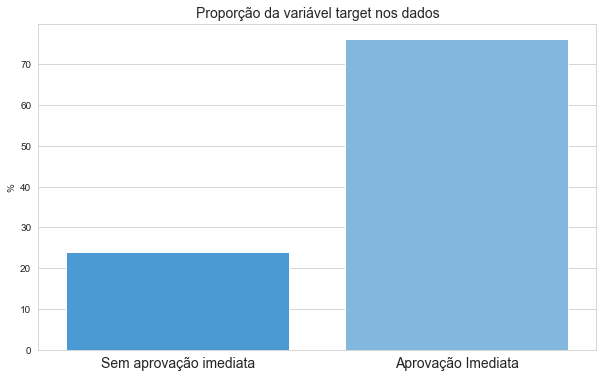

In [29]:
data = np.round((train.target.value_counts() / len(train)) * 100, 2)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x = data.index, y = data, palette=['#349eeb', '#74baed'])
ax.set_title('Proporção da variável target nos dados', fontsize = 14)
ax.set_xticklabels(['Sem aprovação imediata', 'Aprovação Imediata'], fontsize = 14)
ax.set_ylabel('%')
plt.show()

Fica evidente o desbalance de classes, isso será tratado futuramente.

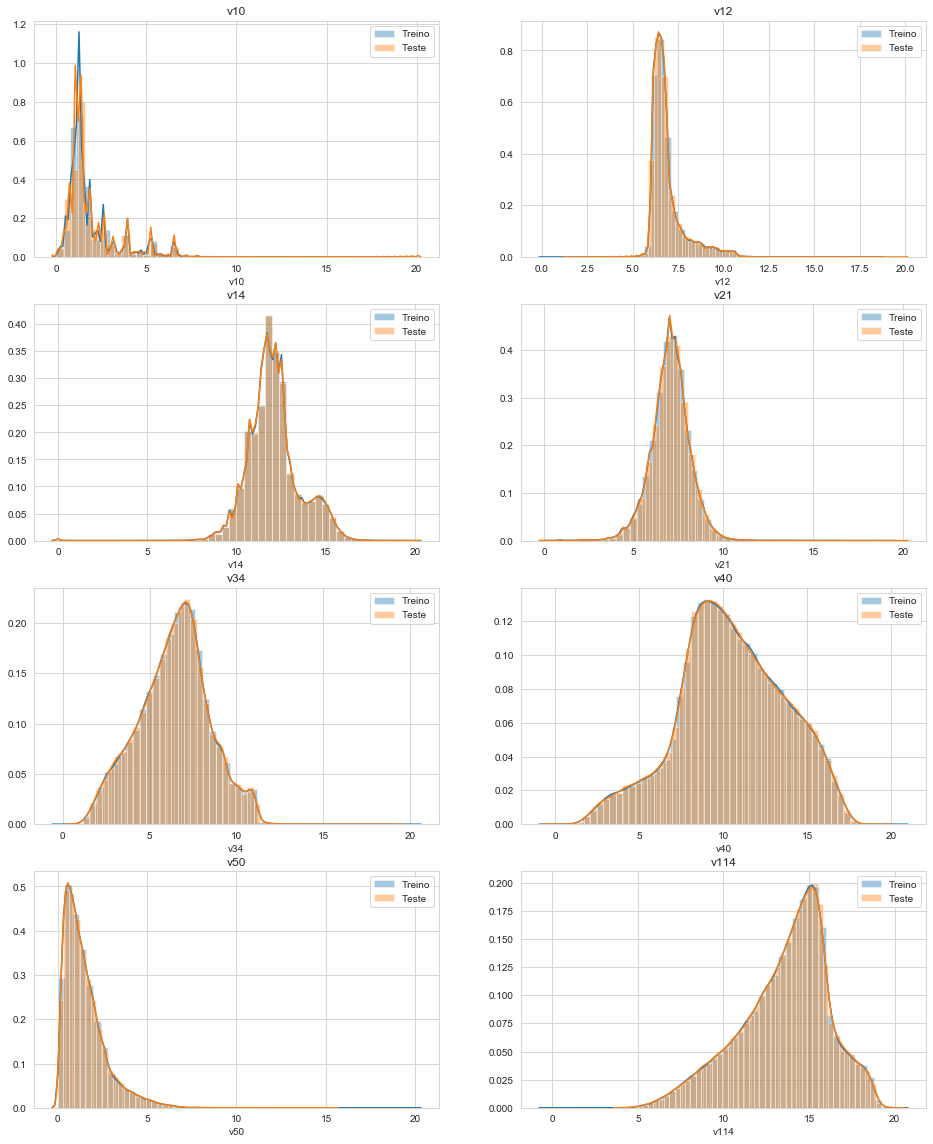

In [30]:
#Distribuição de variáveis contínuas

fig, ax = plt.subplots(4,2,figsize=(16,20))
features = train.select_dtypes('float64').columns.tolist()
k = 0

for i in range(4):
    for j in range(2):
        sns.distplot(train[features[k]], ax = ax[i,j])
        sns.distplot(test[features[k]], ax = ax[i,j])
        ax[i,j].set_title(f'{features[k]}')
        ax[i,j].legend(['Treino', 'Teste'])
        
        k += 1
        

Ok, temos duas informações extremamente relevantes aqui! Primeiro de tudo, a distribuição entre treino e teste é muito similar e segundo é que a skewness de algumas variáveis estão elevadas.

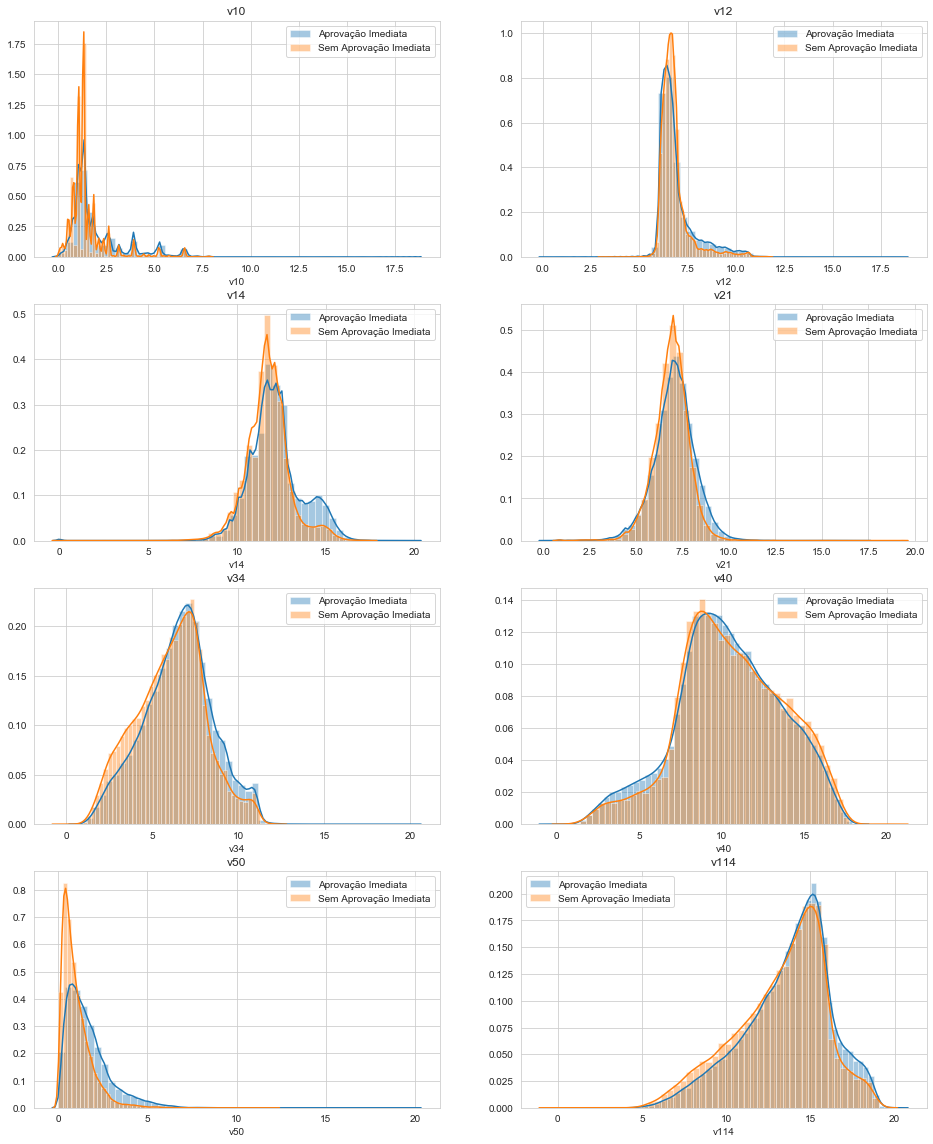

In [31]:
#Distribuição entre aprovados e não aprovados

fig, ax = plt.subplots(4,2,figsize=(16,20))
features = train.select_dtypes('float64').columns.tolist()
k = 0

for i in range(4):
    for j in range(2):
        sns.distplot(train.loc[train.target == 1, features[k]], ax = ax[i,j])
        sns.distplot(train.loc[train.target == 0, features[k]], ax = ax[i,j])
        ax[i,j].set_title(f'{features[k]}')
        ax[i,j].legend(['Aprovação Imediata', 'Sem Aprovação Imediata'])
        
        k += 1


Não existe um comportamento heterogêneo entre positivos e negativos.

In [32]:
#Variáveis Categóricas

train.select_dtypes('object').nunique()

v3          3
v22     18210
v24         5
v31         3
v47        10
v52        12
v56       122
v66         3
v71         9
v74         3
v75         4
v79        18
v91         7
v107        7
v110        3
v112       22
v125       90
dtype: int64

Como ja dito anteriormente, algumas variáveis categóricas possuem uma quantidade muito elevada de valores únicos e por isso serão abordadas separadamente. O objetivo no momento é saber se existe alguma diferença nas categorias entre target 1 e 0.

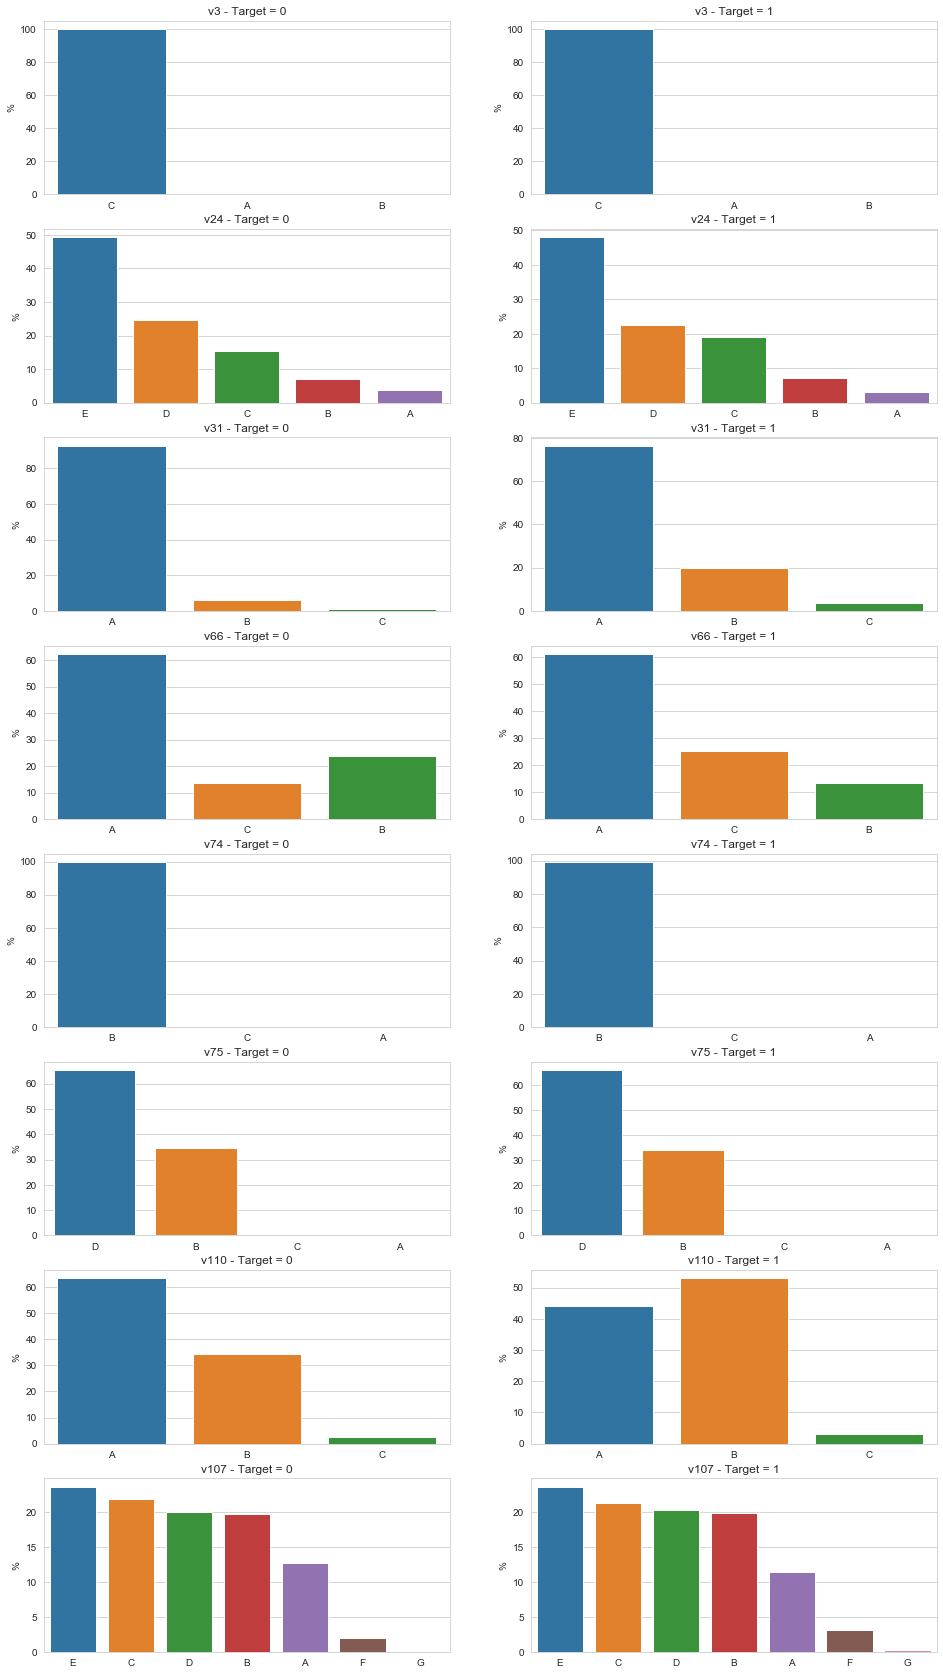

In [33]:
#Avaliando algumas categóricas

cat_features = ['v3', 'v24', 'v31', 'v66', 'v74', 'v75', 'v110', 'v107']

fig, ax = plt.subplots(8,2,figsize=(16,30))
features = train.select_dtypes('float64').columns.tolist()
k = 0

for i in range(8):
    order = train[cat_features[k]].value_counts().index.tolist()
    data_0 = (train.loc[train.target == 0, cat_features[k]].value_counts() / len(train.loc[train.target == 0])) * 100
    data_1 = (train.loc[train.target == 1, cat_features[k]].value_counts() / len(train.loc[train.target == 1])) * 100
    sns.barplot(x = data_0.index, y = data_0, ax = ax[i,0], order = order)
    sns.barplot(x = data_1.index, y = data_1, ax = ax[i,1], order = order)
    ax[i,0].set_title(f'{cat_features[k]} - Target = 0')
    ax[i,0].set_xlabel('')
    ax[i,0].set_ylabel('%')
    ax[i,1].set_title(f'{cat_features[k]} - Target = 1')
    ax[i,1].set_xlabel('')
    ax[i,1].set_ylabel('%')

    
    k += 1

As features acima ja nos permitem conferir um detalhe, para algumas features, a presença de uma classe é absolutamente dominante. Por exemplo a feature "v3", cerca de 100% de seus valores são "C" o que implica em pouco ganho de informação durante a construção do modelo. Vamos tentar observar numéricamente a proporção das classes.

In [34]:
#Para cada feature categórica, qual a proporção da classe dominante?
print('Para treino:')
for feature in train.select_dtypes('object').columns:
    print(f'Para a feature {feature}: {np.round((train[feature].value_counts()[0] / len(train)) * 100, 2)} %')
    
print('\nPara teste:')
for feature in train.select_dtypes('object').columns:
    print(f'Para a feature {feature}: {np.round((test[feature].value_counts()[0] / len(test)) * 100, 2)} %')

Para treino:
Para a feature v3: 99.76 %
Para a feature v22: 2.52 %
Para a feature v24: 48.26 %
Para a feature v31: 80.3 %
Para a feature v47: 48.48 %
Para a feature v52: 9.71 %
Para a feature v56: 15.95 %
Para a feature v66: 61.54 %
Para a feature v71: 65.69 %
Para a feature v74: 99.33 %
Para a feature v75: 65.68 %
Para a feature v79: 30.23 %
Para a feature v91: 23.69 %
Para a feature v107: 23.69 %
Para a feature v110: 48.71 %
Para a feature v112: 19.29 %
Para a feature v125: 5.1 %

Para teste:
Para a feature v3: 99.77 %
Para a feature v22: 2.51 %
Para a feature v24: 48.24 %
Para a feature v31: 80.5 %
Para a feature v47: 48.45 %
Para a feature v52: 9.92 %
Para a feature v56: 16.15 %
Para a feature v66: 61.52 %
Para a feature v71: 65.82 %
Para a feature v74: 99.37 %
Para a feature v75: 65.82 %
Para a feature v79: 30.34 %
Para a feature v91: 23.56 %
Para a feature v107: 23.56 %
Para a feature v110: 48.72 %
Para a feature v112: 19.35 %
Para a feature v125: 5.19 %


Podemos então remover duas features do nosso conjunto de dados: "v3" e "v74".

In [35]:
#Dropando as features
#Treino
train.drop(['v3', 'v74'], axis = 1, inplace = True)

#Teste
test.drop(['v3', 'v74'], axis = 1, inplace = True)

#### Feature v22
Vamos analisar essa feature separadamente. Primeiro, quero responder a seguinte pergunta: Existe alguma "classe" dentro da feature v22 que está frequentemente relacionado a casos positivos/negativos?

In [36]:
train.loc[train.target == 1, 'v22'].value_counts().head()

AGDF    2291
YGJ     1595
QKI      495
PWR      490
HZE      310
Name: v22, dtype: int64

In [37]:
train.loc[train.target == 0, 'v22'].value_counts().head()

AGDF    595
YGJ     524
QKI     173
PWR     159
HZE     113
Name: v22, dtype: int64

In [38]:
data = train.loc[train.target == 1, 'v22'].value_counts()
data = data[data < 10]
len(data)

14316

O código acima mostra duas coisas: A distribuição entre as classes não é assim tão absurda e dos 16 mil registros unicos na feature 'v22', cerca de 14 mil possuem menos de 10 registros.

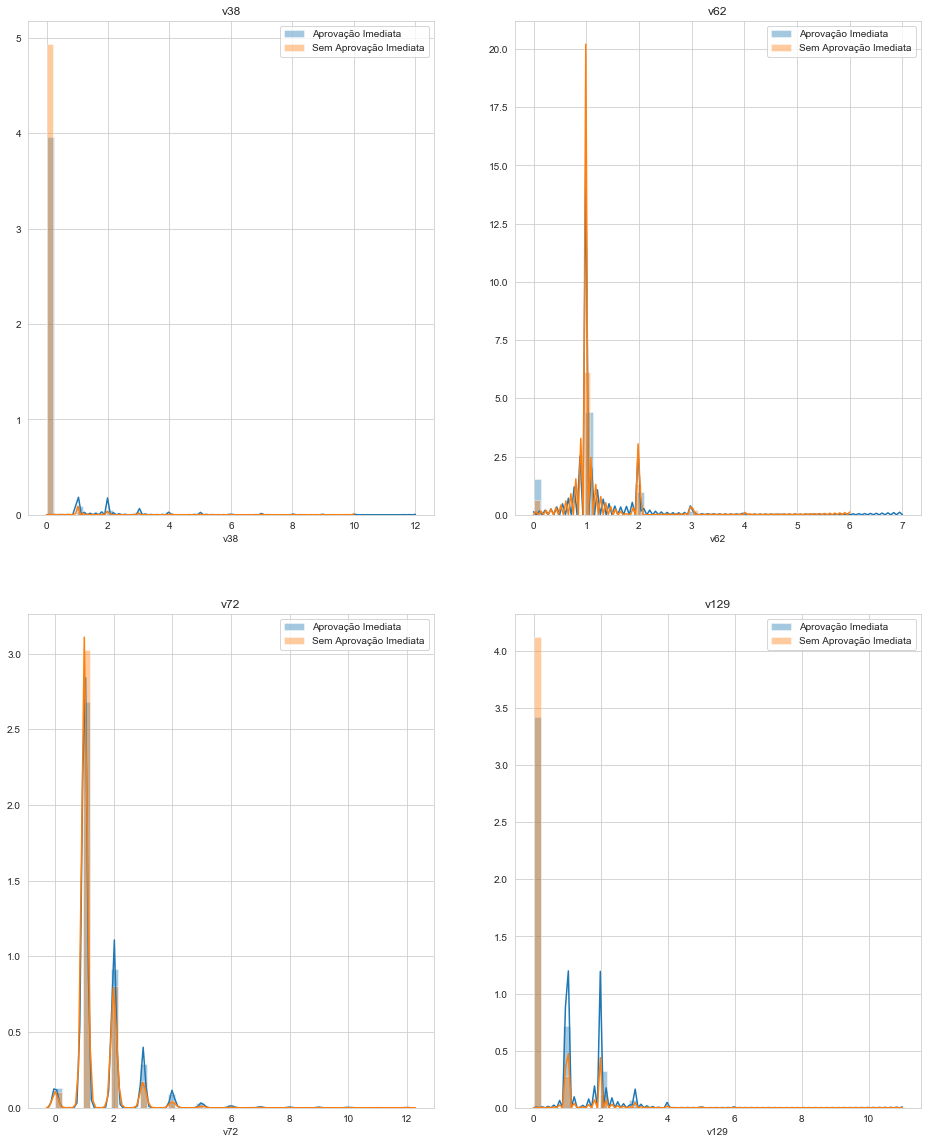

In [39]:
#Distribuição entre aprovados e não aprovados para int64

fig, ax = plt.subplots(2,2,figsize=(16,20))
features = train.select_dtypes('int64').drop(['ID', 'target'], axis = 1).columns.tolist()
k = 0

for i in range(2):
    for j in range(2):
        sns.distplot(train.loc[train.target == 1, features[k]], ax = ax[i,j])
        sns.distplot(train.loc[train.target == 0, features[k]], ax = ax[i,j])
        ax[i,j].set_title(f'{features[k]}')
        ax[i,j].legend(['Aprovação Imediata', 'Sem Aprovação Imediata'])
        
        k += 1


### Encoding de categóricas
Baseado na análise que realizamos préviamente, o "approach" para as categóricas será o seguinte:
- Categóricas que possuirem mais de 10 elementos únicos, terão os seus 10 elementos mais frequentes mantidos e o restante será adicionado a uma categoria "Outro"
- Após transformação, aplicar One-Hot Encoding nas categóricas.

In [40]:
def change_value(x, to_keep):
    if x not in to_keep:
        return 'Outro'
    else:
        return x


def select_categorical(dataframe, features):
    for col in features:
        if dataframe[col].nunique() > 10:
            to_keep = dataframe[col].value_counts()[:10]
            dataframe[col] = dataframe[col].apply(lambda x: change_value(x, to_keep))
            

#Aplicando
features = train.select_dtypes('object').columns
#Treino
select_categorical(train, features)

#Teste
select_categorical(test, features)
            
    

In [41]:
#Verificando o resultado

train.select_dtypes('object').nunique()

v22     11
v24      5
v31      3
v47     10
v52     11
v56     11
v66      3
v71      9
v75      4
v79     11
v91      7
v107     7
v110     3
v112    11
v125    11
dtype: int64

Conforme esperado, agora o máximo de features permitidas são 11 (As 10 mantidas + "Outro")

In [42]:
#One-hot encoding

#Treino
train = pd.get_dummies(data = train, columns=features)

#Teste
test = pd.get_dummies(data = test, columns=features)



In [43]:
#Verificando

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (114321, 131)
Test shape: (114393, 129)


### Análise de Skewness
Espelho espelho meu, existe alguma distribuição mais normal do que eu?

Como observado nos gráficos de variáveis contínuas (float64), algumas distribuições estavam bem "tortas". A esse grau de inclinação lateral damos o nome de skewness, e em termos gerais, skewness elevadas não são a condição "ideal" para a modelagem e por isso podemos testar algumas transformações para deixar essa distribuição mais conformada. Primeiro de tudo, vamos ver a skewness numéricamente.

In [44]:
#Skewness para variáveis contínuas

cont_vars = train.select_dtypes('float64').columns
print('Treino')
print('Feature   -    Skewness\n')
for var in cont_vars:
    print(f'{var}       -    {sci.skew(train[var])}')

print('\nTeste')
print('Feature   -    Skewness\n')
for var in cont_vars:
    print(f'{var}       -    {sci.skew(test[var])}')

Treino
Feature   -    Skewness

v10       -    1.8595307301517081
v12       -    2.004363624597366
v14       -    0.01548003634843826
v21       -    -0.16153958684255926
v34       -    -0.07600026679665936
v40       -    -0.14213766634119332
v50       -    1.7043711968394941
v114       -    -0.5737359641688133

Teste
Feature   -    Skewness

v10       -    1.8702835617608222
v12       -    2.0366318514289428
v14       -    0.025778410791045633
v21       -    -0.16369440898189433
v34       -    -0.07704883531870932
v40       -    -0.1395749404977595
v50       -    1.6246409938035036
v114       -    -0.5739745413124971


Quanto mais próximo de 0, melhor. Vamos aplicar transformações para variáveis que possuem skewness absoluta maior que 0.5 e verificar o resultado da transformação.

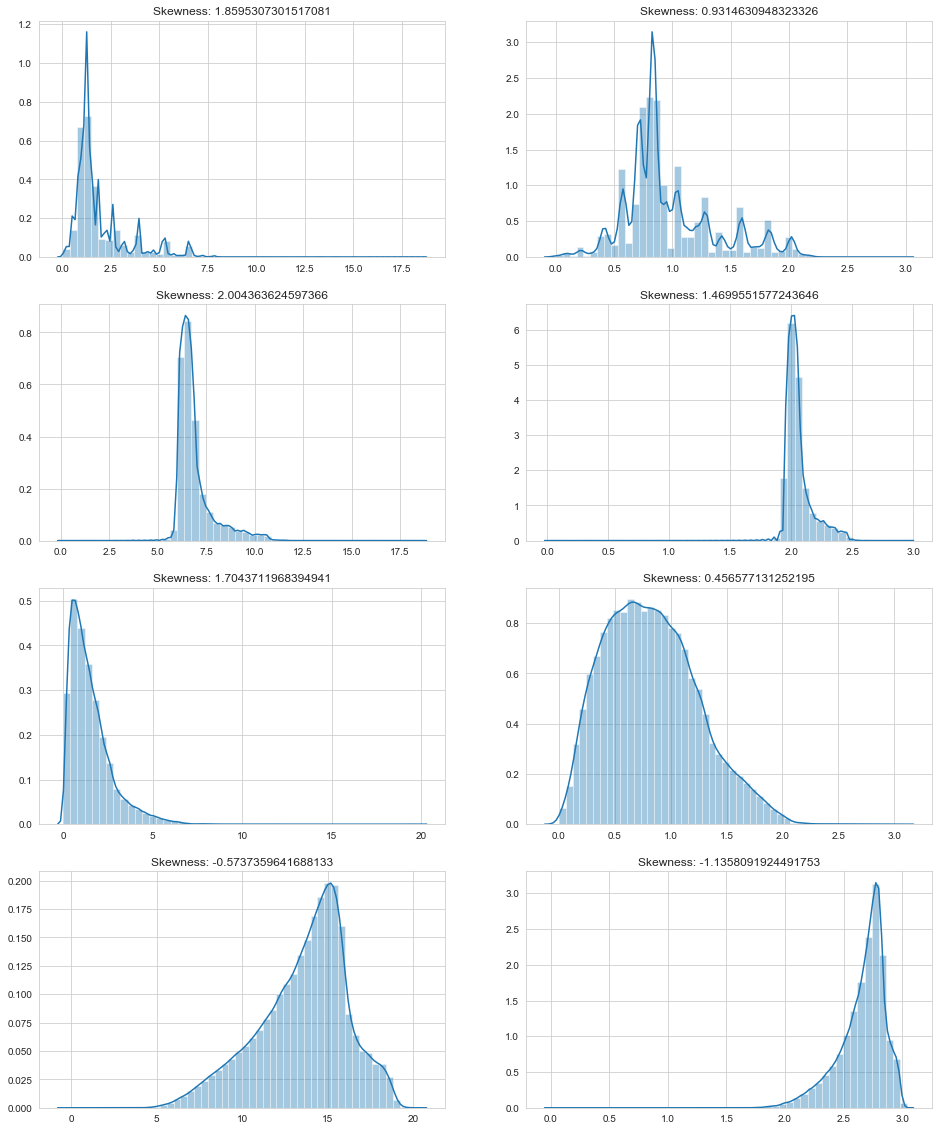

In [45]:
#Gerando dados
skew_train = pd.DataFrame(columns=['feature', 'skew'])
skew_test = pd.DataFrame(columns=['feature', 'skew'])

for var in cont_vars:
    skew_train = pd.concat([skew_train, pd.DataFrame({'feature': var, 'skew': abs(sci.skew(train[var]))}, index = [0])], ignore_index=True)
    skew_test = pd.concat([skew_test, pd.DataFrame({'feature': var, 'skew': abs(sci.skew(test[var]))}, index = [0])], ignore_index=True)

#Filtrando skewness
to_filter = skew_train.loc[skew_train['skew'] > 0.5, 'feature'].tolist()

#Aplicando transformações
k = 0

fig,ax = plt.subplots(4,2,figsize=(16,20))

for i in range(4):
    sns.distplot(train[to_filter[k]], ax = ax[i, 0])
    sns.distplot(np.log1p(train[to_filter[k]]), ax = ax[i,1])
    ax[i,0].set_title(f'Skewness: {sci.skew(train[to_filter[k]])}')
    ax[i,1].set_title(f'Skewness: {sci.skew(np.log1p(train[to_filter[k]]))}')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    k += 1
    

In [46]:
to_filter

['v10', 'v12', 'v50', 'v114']

Para três features houve diminuição da skewness! Logo, vamos manter essa transformação em nosso dataframe.

In [47]:
#Teste de features
train['v10_min_mean'] = train.v10 - train.v10.mean()
train['v10_std'] = train.v10_min_mean / train.v10.std()
train['v12_min_mean'] = train.v12 - train.v12.mean()
train['v12_std'] = train.v12_min_mean / train.v12.std()
train['v14_min_mean'] = train.v14 - train.v14.mean()
train['v14_std'] = train.v14_min_mean / train.v14.std()
train['v21_min_mean'] = train.v21 - train.v21.mean()
train['v21_std'] = train.v21_min_mean / train.v21.std()
train['v34_min_mean'] = train.v34 - train.v34.mean()
train['v34_std'] = train.v34_min_mean / train.v34.std()
train['v40_min_mean'] = train.v40 - train.v40.mean()
train['v40_std'] = train.v40_min_mean / train.v40.std()
train['v50_min_mean'] = train.v50 - train.v50.mean()
train['v50_std'] = train.v50_min_mean / train.v50.std()
train['v114_min_mean'] = train.v114 - train.v114.mean()
train['v114_std'] = train.v114_min_mean / train.v114.std()

test['v10_min_mean'] = test.v10 - test.v10.mean()
test['v10_std'] = test.v10_min_mean / test.v10.std()
test['v12_min_mean'] = test.v12 - test.v12.mean()
test['v12_std'] = test.v12_min_mean / test.v12.std()
test['v14_min_mean'] = test.v14 - test.v14.mean()
test['v14_std'] = test.v14_min_mean / test.v14.std()
test['v21_min_mean'] = test.v21 - test.v21.mean()
test['v21_std'] = test.v21_min_mean / test.v21.std()
test['v34_min_mean'] = test.v34 - test.v34.mean()
test['v34_std'] = test.v34_min_mean /test.v34.std()
test['v40_min_mean'] = test.v40 - test.v40.mean()
test['v40_std'] = test.v40_min_mean / test.v40.std()
test['v50_min_mean'] = test.v50 - test.v50.mean()
test['v50_std'] = test.v50_min_mean / test.v50.std()
test['v114_min_mean'] = test.v114 - test.v114.mean()
test['v114_std'] = test.v114_min_mean / test.v114.std()

train.head()

,ID,target,v10,v12,v14,v21,v34,v38,v40,v50,...,v21_min_mean,v21_std,v34_min_mean,v34_std,v40_min_mean,v40_std,v50_min_mean,v50_std,v114_min_mean,v114_std
0,3,1,0.503281,6.085711,11.636387,7.730923,7.270147,0,7.711453,0.899420,...,0.701183,0.655678,0.863911,0.426792,-2.754475,-0.869566,-0.604845,-0.517895,2.060456,0.788577
1,4,1,1.312910,6.507647,11.636386,6.763110,3.615077,0,14.305766,1.379210,...,-0.266631,-0.249327,-2.791158,-1.378898,3.839838,1.212206,-0.125055,-0.107078,-3.266407,-1.250118
2,5,1,0.765864,6.384670,9.603542,5.245035,4.043864,0,13.077201,0.604504,...,-1.784705,-1.668882,-2.362371,-1.167067,2.611273,0.824358,-0.899761,-0.770416,-2.368890,-0.906621
3,6,1,6.542669,9.646653,14.094723,7.517125,8.703550,0,11.523045,3.329176,...,0.487385,0.455754,2.297314,1.134927,1.057116,0.333723,1.824912,1.562572,0.203215,0.077775
4,8,1,1.050328,6.320087,10.991098,6.414567,6.083151,0,10.138920,1.364536,...,-0.615173,-0.575250,-0.323085,-0.159612,-0.327009,-0.103234,-0.139729,-0.119642,0.522648,0.200028


In [48]:
#Aplicando transformação

train['exp_v10'] = np.exp(train.v10)
train['exp_v12'] = np.exp(train.v12)
train['exp_v14'] = np.exp(train.v14)
train['exp_v21'] = np.exp(train.v21)
train['exp_v34'] = np.exp(train.v34)
train['exp_v40'] = np.exp(train.v40)
train['exp_v50'] = np.exp(train.v50)

test['exp_v10'] = np.exp(test.v10)
test['exp_v12'] = np.exp(test.v12)
test['exp_v14'] = np.exp(test.v14)
test['exp_v21'] = np.exp(test.v21)
test['exp_v34'] = np.exp(test.v34)
test['exp_v40'] = np.exp(test.v40)
test['exp_v50'] = np.exp(test.v50)



#Treino
train['v10'] = np.log1p(train.v10)
train['v12'] = np.log1p(train.v12)
train['v50'] = np.log1p(train.v50)

#Teste
test['v10'] = np.log1p(test.v10)
test['v12'] = np.log1p(test.v12)
test['v50'] = np.log1p(test.v50)

In [49]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree =3,
                         interaction_only=True,
                         include_bias=False,
                         )

to_poly = ['v10', 'v12', 'v14', 'v21', 'v34', 'v40', 'v50']

poly_features = pd.DataFrame(poly.fit_transform(train[to_poly]))
poly_test = pd.DataFrame(poly.fit_transform(test[to_poly]))

train = pd.concat([train, poly_features], axis = 1)

test = pd.concat([test, poly_test], axis = 1)

train.head()


,ID,target,v10,v12,v14,v21,v34,v38,v40,v50,...,53,54,55,56,57,58,59,60,61,62
0,3,1,0.407650,1.958080,11.636387,7.730923,7.270147,0,7.711453,0.641549,...,654.022498,693.722447,57.713720,652.375365,54.273880,57.568370,433.421814,36.058203,38.246979,35.967392
1,4,1,0.838506,2.015922,11.636386,6.763110,3.615077,0,14.305766,0.866769,...,284.499917,1125.837345,68.213081,601.792600,36.461863,144.288715,349.764035,21.191767,83.861123,44.826194
2,5,1,0.568640,1.999406,9.603542,5.245035,4.043864,0,13.077201,0.472815,...,203.693153,658.710583,23.816110,507.858606,18.361959,59.379594,277.370203,10.028500,32.430542,25.003591
3,6,1,2.020576,2.365246,14.094723,7.517125,8.703550,0,11.523045,1.465377,...,922.156679,1220.887223,155.259352,1413.579397,179.763878,237.997974,753.902910,95.873292,126.931226,146.964734
4,8,1,0.718000,1.990622,10.991098,6.414567,6.083151,0,10.138920,0.860582,...,428.881171,714.825610,60.673709,677.893286,57.538929,95.901389,395.628526,33.580568,55.969466,53.077736


### Correlação

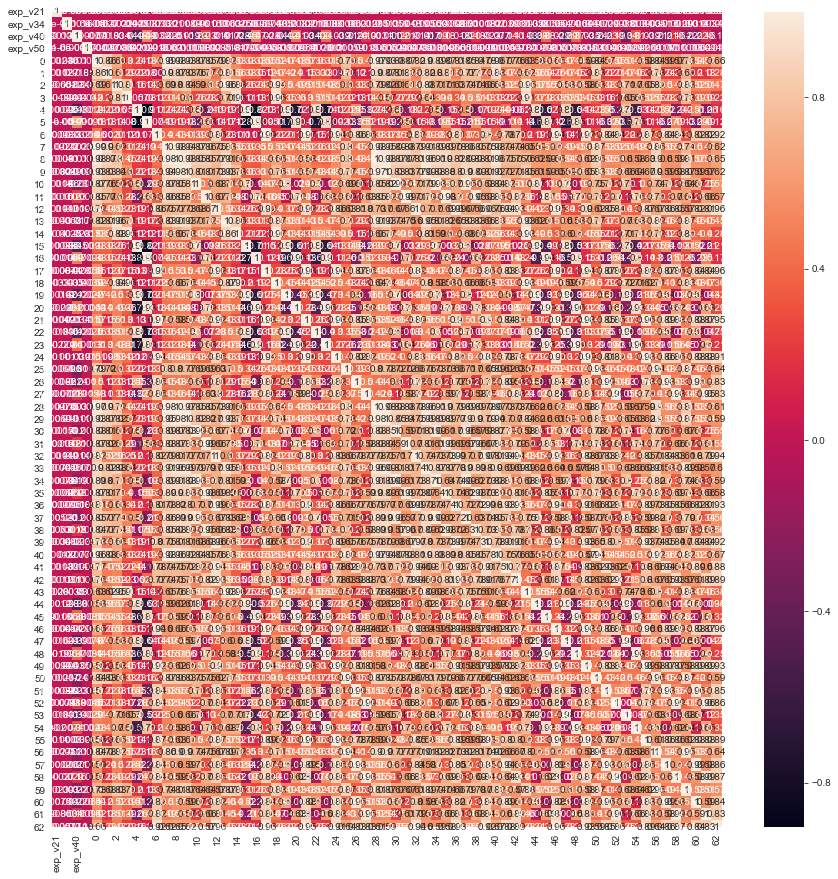

In [50]:
data = train.iloc[:, 150:]
data_corr = data.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data_corr, annot=True, ax = ax)


## Modelagem

Primeiro de tudo, é preciso alinhar as features de treino e teste.

In [51]:
#full = pd.concat([train, test], ignore_index = True)
#full.isnull().sum()[full.isnull().sum() > 0]

#termino em 93 - Treino
#termino em 21 - Teste

drop_train = ['v22_GBS', 'v47_H', 'v52_K', 'v71_A', 'v71_D', 'v71_K']
drop_test = ['v22_VZF', 'v52_A', 'v71_E', 'v71_H', 'v71_J']

train.drop(drop_train, axis = 1, inplace = True)
test.drop(drop_test,axis = 1, inplace = True)

print('Treino:', train.shape)
print('Teste:', test.shape)

Treino: (114321, 211)
Teste: (114393, 210)


In [52]:
x = train.loc[:, train.columns != 'target'].drop(['ID'], axis = 1).values
y = train['target'].values
x_test = test.drop('ID', axis = 1).values

### Modelo : XGB

In [58]:

clf = XGBClassifier(
                          max_depth=6,
                           learning_rate = 0.037820584183860674,
                           n_estimators=201,
                           subsample = 0.6459969497862531,
                           reg_alpha = 0.80082029532047,
                           gamma = 0.6720139426712002,
                          
                             random_state=42)


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#clf.fit(x,y)
print('Para os dados puros, XGB otimizado, o score médio em um CV de 5 folds é:')
#print(np.mean(cross_val_score(estimator = clf, X = x, y = y, scoring = 'neg_log_loss', cv = 5, verbose = True, n_jobs = 6)))
#-0.46722432544593123 - Sem bins


Para os dados puros, XGB otimizado, o score médio em um CV de 5 folds é:


In [59]:
clf.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.6720139426712002,
              learning_rate=0.037820584183860674, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=201, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.80082029532047, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6459969497862531,
              verbosity=1)

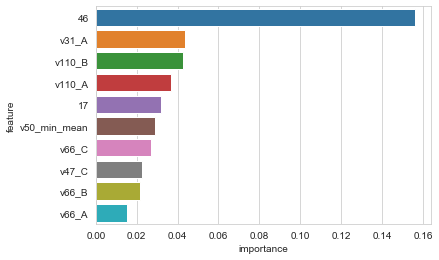

In [60]:
feature_data = pd.DataFrame({'feature': train.drop(['ID', 'target'], axis = 1).columns,
                            'importance':clf.feature_importances_})

feature_data = feature_data.loc[feature_data.importance > 0]

sns.barplot(data = feature_data.sort_values(by = 'importance', ascending=False).head(10), x = 'importance', y = 'feature')

#sns.barplot(x = , y = )

In [ ]:
clf.feature_importances_

### Modelo: LGBM

In [ ]:
from lightgbm import LGBMClassifier

clf2 = LGBMClassifier(num_leaves = 54,
                     max_depth = 18,
                     learning_rate = 0.04976663882058719,
                     n_estimators= 191,
                     subsample = 0.8260161614762738,
                     reg_alpha = 0.3292146773536071)

#clf2.fit(x,y)
print('Para os dados puros, LGBM otimizado, o score médio em um CV de 5 folds é:')
#print(np.mean(cross_val_score(estimator = clf2, X = x, y = y, scoring = 'neg_log_loss', cv = 5, verbose = True, n_jobs = 6)))

### Modelo: CatBoost

In [ ]:
from catboost import CatBoostClassifier

clf3 = CatBoostClassifier(iterations=190,
                        learning_rate = 0.03604037723646267,
                        depth = 11,
                        l2_leaf_reg=0.4753378283103702,
                        bootstrap_type='Bernoulli',
                               verbose=True,
                               early_stopping_rounds=10,
                               random_seed=42
                       
                        )

#clf3.fit(x,y)
print('Para os dados puros, CatBoost otimizado, o score médio em um CV de 5 folds é:')
#print(np.mean(cross_val_score(estimator = clf3, X = x, y = y, scoring = 'neg_log_loss', cv = 5, verbose = True, n_jobs = 6)))

### Modelo: Stack Classifier

In [ ]:
clf4 = StackingClassifier(classifiers=[clf,clf2,clf3],
                         meta_classifier=clf,
                         use_probas = True,
                         drop_last_proba=True,
                         )

print('Para os dados puros, StackingClassifier otimizado, o score médio em um CV de 5 folds é:')
#print(np.mean(cross_val_score(estimator = clf4, X = x, y = y, scoring = 'neg_log_loss', cv = 5, verbose = True, n_jobs = 6)))

### Otimização

In [67]:
from skopt import gp_minimize

#Função para minimizar

def func(params):
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y)
    
    
    learning_rate = params[0]
    n_estimators = params[1]
    subsample = params[2]
    reg_alpha = params[3]
    gamma = params[4]
    max_depth = params[5]
    min_child_weight = params[6]
    max_delta_step = params[7]
    scale_pos_weight = params[8]
    
    model = XGBClassifier(
                          max_depth=max_depth,
                           learning_rate = learning_rate,
                           n_estimators=n_estimators,
                           subsample = subsample,
                           #reg_alpha = reg_alpha,
                           #gamma = gamma,
                          
                             random_state=42)
    
    


    
    #learning_rate = params[0]
    #max_iter = params[1]
    #max_leaf_nodes = params[2]
    #max_depth = params[3]
    #l2_regularization = params[4]
    
    
    #model = HistGradientBoostingClassifier(learning_rate=0.05892210943459556,
    #                                      max_iter=271,
    #                                     max_leaf_nodes=47,
    #                                      max_depth=6,
    #                                      l2_regularization=0.12168427793749205)
    
    
    
    #num_leaves = params[0]
    #max_depth = params[1]
    #learning_rate = params[2]
    #n_estimators = params[3]
    #subsample = params[4]
    #reg_alpha = params[5]
    
    #model = LGBMClassifier(num_leaves = num_leaves,
    #                max_depth = max_depth,
    #                 learning_rate = learning_rate,
    #                 n_estimators= n_estimators,
    #                 subsample = subsample,
    #                 reg_alpha = reg_alpha)
    
    
    #iterations = params[0]
    #learning_rate = params[1]
    #depth = params[2]
    #l2_leaf_reg = params[3]
    
    #model = CatBoostClassifier(iterations=iterations,
    #                    learning_rate = learning_rate,
    #                    depth = depth,
    #                    l2_leaf_reg=l2_leaf_reg,
    #                    bootstrap_type='Bernoulli',
    #                           verbose=False,
    #                           early_stopping_rounds=10,
    #                           random_seed=42
    #                   
    #                   )
    
    
    model.fit(x_train, y_train)
    
    return log_loss(y_test, model.predict_proba(x_test))



space = [
        (0.01, 0.08),
        (100, 250),
        (0.1,0.99),
        (0.1,0.99),
        (0.1,0.99),
        (4,10),
        (0.1,0.9),
        (0.1,0.99),
        (0.1,0.99)
    ]


#space = [
#    (10, 90),
#    (2, 20),
#    (0.01, 0.3),
#    (50, 250),
#    (0.1, 0.99),
#    (0.1, 0.99)
#]


#space = [
#    (0.01, 0.07),
#    (50, 250),
#    (0.1, 0.99),
#    (0.1, 0.99),
#   (0.1, 0.8),
#]

#space = [(1e-2, 0.2),
#        (50,300),
#        (1, 100),
#        (4, 10),
#        (0.1, 0.99)]

result = dummy_minimize(func, space, n_calls= 20, verbose = True)
#[8, 0.02676708990759656, 121, 0.2721573712002765, 0.7527057433333327, 0.186381621928499, 0.24603281653974754] - 0.4683
#[6, 0.051762059105206086, 235, 0.5541104251122431, 0.9513731733398064, 0.2708045366993933, 0.6684199445270224] - 0.4640 #XGB
#[6, 0.07228022958666085, 199, 57, 0.49789563803719816, 43] #HistBoost
#[7, 0.068611774254308, 185, 42, 0.5181009821812094, 64, 120] - HistBoost - 0.4641
#[0.05892210943459556, 271, 47, 6, 0.12168427793749205]
#[8, 0.034782478457189216, 208, 0.6498275664915653, 0.9484845975060061, 0.6365455417815948] - XGB
#[6, 0.04177365514227746, 248, 0.9270045339135777, 0.9160478677684891, 0.6784739247494446]

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 132.9616
Function value obtained: 0.4752
Current minimum: 0.4752
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 176.9063
Function value obtained: 0.4737
Current minimum: 0.4737
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 202.8734
Function value obtained: 0.4733
Current minimum: 0.4733
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 157.4200
Function value obtained: 0.4737
Current minimum: 0.4733
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 197.5287
Function value obtained: 0.4729
Current minimum: 0.4729
Iteration No: 6 started. 

In [68]:
result.x

[0.04723871681220819,
 218,
 0.8984512864940226,
 0.3931914832482474,
 0.4822806974500934,
 6,
 0.14126725373704183,
 0.10392378443859279,
 0.14611795586243087]

### Classifier Stacking

In [ ]:
'''base_models = {
              'rf': RandomForestClassifier(max_depth=8),
              'histboost': HistGradientBoostingClassifier(  max_depth = 7,
                                             learning_rate = 0.068611774254308,
                                             max_iter = 185,
                                             min_samples_leaf = 42,
                                             l2_regularization = 0.5181009821812094,
                                             max_leaf_nodes = 64,
                                            random_state = 42,
                                            max_bins = 120,
                                           scoring = 'log_loss'
                                             ),
              }

#Agora, precisamos gerar para cada modelo acima predições dentro do treino utilizando cv

class ModelStacking:
    def __init__(self, x_train, y_train, x_test, cv, seed, models):
        self._x = x_train
        self._y = y_train
        self._x_test = x_test
        self.cv = cv
        self.seed = seed
        self.models = models
        
    
    def make_predict(self):
        #Cross-validation
        kfold = StratifiedKFold(n_splits = self.cv, random_state=self.seed)
        
        #Predicts
        train_predicts = dict()
        test_predicts = dict()
        
        #Para cada modelo
        for label, model in self.models.items():
            print(f'\nFitting {label}...')
            predicts = np.zeros((len(self._x), 2))
            k = 1
            
            for train_index, pred_index in kfold.split(self._x, self._y):
                print(f'Treino : {k}º Fold iniciado...')
                
                x_train, y_train, x_pred = self._x[train_index], self._y[train_index], self._x[pred_index]
                model.fit(x_train, y_train)
                predicts[pred_index] = model.predict_proba(x_pred)
                k += 1
                
            train_predicts[label] = predicts
            
            print('Treinando modelo em teste...')
            model.fit(self._x, self._y)
            predict_test = model.predict_proba(self._x_test)
            test_predicts[label] = predict_test
            
        print('Features criadas!')
        return train_predicts, test_predicts
'''

In [ ]:
'''stack = ModelStacking(x_train = x, 
                      y_train = y, 
                      x_test = test.drop('ID', axis = 1).values, 
                      cv = 5, 
                      seed = 42, 
                      models = base_models)

train_stack, test_stack = stack.make_predict()'''

In [ ]:
#Aplicando as features

#Treino
#train['rf'] = train_stack['rf'][:,1]
#train['histboost'] = train_stack['histboost'][:,1]
#train['lr'] = train_stack['lr'][:,1]

#Test
#test['rf'] = test_stack['rf'][:,1]
#test['histboost'] = test_stack['histboost'][:,1]
#test['lr'] = test_stack['lr'][:, 1]


train.head()

In [ ]:
#train.drop(['v34', 'v114'], axis = 1, inplace = True)
#train_raw.drop(['v34', 'v114'], axis = 1, inplace = True)
#test.drop(['v34', 'v114'], axis = 1, inplace = True)
#test_raw.drop(['v34', 'v114'], axis = 1, inplace = True)

In [ ]:
x = train.drop(['ID', 'target'], axis = 1).values
y = train['target'].values
x_test = test.drop('ID', axis = 1).values

In [ ]:
train.head()

In [ ]:
sns.distplot(train.v114_min_mean)

### Validação

In [ ]:
'''
model = XGBClassifier(max_depth=6,
                   learning_rate = 0.051762059105206086,
                   n_estimators=235,
                   subsample = 0.5541104251122431,
                   reg_alpha = 0.9513731733398064,
                   reg_lambda = 0.2708045366993933,
                   gamma=0.6684199445270224)


scores_ss = list()


def cross_validation(cv):
    fold = StratifiedKFold(n_splits = cv, random_state=42)
    
    for train_index, test_index in fold.split(x, y):
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        model.fit(x_train, y_train)
        print(f'Log_loss: {log_loss(y_test, model.predict_proba(x_test))}')
        scores_ss.append(log_loss(y_test, model.predict_proba(x_test)))
        
    print(f'\nLog_loss médio : {np.mean(scores_ss)}')
    
    
cross_validation(5)

#Sem feature de stacking - 0.46726
#Sem feature de stacking - 0.4695  - Com feature rf
#Sem feature v34 - 0.4669'''


## Gerando submit

In [ ]:
'''from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

clf1 = RandomForestClassifier(n_estimators=115,
                             max_depth=19,
                             min_samples_leaf=2)

clf2 = XGBClassifier(max_depth=6,
                   learning_rate = 0.051762059105206086,
                   n_estimators=235,
                   subsample = 0.5541104251122431,
                   reg_alpha = 0.9513731733398064,
                   reg_lambda = 0.2708045366993933,
                   gamma=0.6684199445270224)

clf3 = LogisticRegression()
clf4 = HistGradientBoostingClassifier(learning_rate=0.05892210943459556,
                                          max_iter=271,
                                          max_leaf_nodes=47,
                                          max_depth=6,
                                          l2_regularization=0.12168427793749205)


stack = StackingCVClassifier(classifiers=[clf1, clf2,clf3,clf4],
                            meta_classifier=clf2,
                            use_probas=True,
                             stratify=True,
                             drop_last_proba=True,
                            random_state=42)


#cross_val_score(stack, x, y, cv = 5, scoring='neg_log_loss')
'''

In [ ]:
#stack.fit(x, y)

In [ ]:
##RFE

from sklearn.feature_selection import RFE

rfe = RFE(clf)
rfe.fit(x, y)

In [ ]:
columns_selected = train.drop(['ID', 'target'], axis = 1).columns[rfe.support_]
print(columns_selected)

x = train[columns_selected].values
y = train['target']
x_test = test[columns_selected].values

In [ ]:
clf =  XGBClassifier(
                          max_depth=5,
                           learning_rate = 0.06502562076304713,
                           n_estimators=171,
                           subsample = 0.8957300263929866,
                           reg_alpha = 0.6717309859837639,
                           gamma = 0.809709417760169,
                          
                             random_state=42)



scaler = StandardScaler()
sampler = RandomUnderSampler()
#x_scaled = scaler.fit_transform(x)
#x_scaled, y = sampler.fit_resample(x, y)


clf.fit(x,y)

In [61]:
#predicts = clf.predict_proba(x_test.values)
predicts = clf.predict_proba(x_test)

In [62]:
predicts

array([[0.7430308 , 0.25696924],
       [0.11573696, 0.88426304],
       [0.12015975, 0.87984025],
       ...,
       [0.17072833, 0.8292717 ],
       [0.07467538, 0.9253246 ],
       [0.52387595, 0.47612402]], dtype=float32)

### Podando predições

In [63]:
predicts = predicts[:,1]
#predicts = [0.20 if x < 0.05 else x for x in predicts]
#predicts = [0.80 if x > 0.95 else x for x in predicts]
predicts = pd.Series(predicts)

In [64]:
submit = pd.read_csv('datasrc/sample_submission.csv')
submit['PredictedProb'] = predicts
submit.head()
submit.to_csv('submit.csv', index = False)

In [ ]:
print(result.x)

In [ ]:
x = train.drop(['ID', 'target', 'v10'], axis = 1).values
y = train['target'].values
#x_test = test.drop(['ID', 'v10'], axis = 1).values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
stack.fit(x_train, y_train)
print(log_loss(y_test, stack.predict_proba(x_test)))

#0.466 - Sem SMOTE
#0.478 - com SMOTE
#0.5869 - RandomUnderSampler
#0.503 - RandomOverSampler()
#Sem v10 - 4645
#0.4645


In [ ]:
#Utilizando Random Forest

clf = Pipeline([('std', StandardScaler()), ('rf', RandomForestClassifier(max_depth = 8, class_weight='balanced'))])
clf2 = Pipeline([('xgb', XGBClassifier())])
clf3 = Pipeline([('std', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10))])
clf.fit(x_train, y_train)
clf2.fit(x_train, y_train)
clf3.fit(x_train, y_train)

In [ ]:
log_loss(y_test, clf3.predict_proba(x_test))